---

# Lib


In [2]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from xgboost import XGBClassifier
import optuna
from imblearn.over_sampling import SMOTE

---

# Read file


In [44]:
df_train = pd.read_csv("../data/processed/train.csv", encoding="utf-8")
df_1 = pd.read_csv("../data/processed/val.csv", encoding="utf-8")
df_2 = pd.read_csv("../data/processed/test.csv", encoding="utf-8")
df_val = pd.concat([df_1, df_2], axis=0)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3228 entries, 0 to 3591
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    3228 non-null   object
 1   model    3228 non-null   object
 2   version  2264 non-null   object
 3   year     3228 non-null   int64 
 4   segment  3228 non-null   object
 5   comment  3228 non-null   object
 6   label    3228 non-null   object
dtypes: int64(1), object(6)
memory usage: 201.8+ KB


In [8]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384 entries, 0 to 769
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    1384 non-null   object
 1   model    1384 non-null   object
 2   version  948 non-null    object
 3   year     1384 non-null   int64 
 4   segment  1384 non-null   object
 5   comment  1384 non-null   object
 6   label    1384 non-null   object
dtypes: int64(1), object(6)
memory usage: 86.5+ KB


---

# Labels


## Train


In [45]:
matrix_labels_train = df_train["label"]

In [46]:
matrix_labels_train.head()

0    negative
1    positive
2     neutral
3    positive
4    negative
Name: label, dtype: object

In [47]:
print(f"Number of labels: {len(matrix_labels_train.unique())}")
print(f"Labels: {matrix_labels_train.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


## Val


In [48]:
matrix_labels_val = df_val["label"]

In [49]:
matrix_labels_val.head()

0    positive
1    positive
2    positive
3    negative
4    positive
Name: label, dtype: object

In [50]:
print(f"Number of labels: {len(matrix_labels_val.unique())}")
print(f"Labels: {matrix_labels_val.unique()}")

Number of labels: 3
Labels: ['positive' 'negative' 'neutral']


---

# Train, val split


In [51]:
# Train
X_train = df_train[["comment"]]
y_train = matrix_labels_train

# Validation
X_val = df_val[["comment"]]
y_val = matrix_labels_val

In [52]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train).astype(np.int64)
print(f"Labels: {le.classes_}")

Labels: ['negative' 'neutral' 'positive']


---

# Vectorize


In [53]:
vec = TfidfVectorizer(
    analyzer="char",
    min_df=2,
    max_df=0.95,
    ngram_range=(3, 5),
    max_features=35000,
)

In [54]:
# Fit TF-IDF on training and transform train/test
X_train_vec = vec.fit_transform(X_train["comment"])
X_val_vec = vec.transform(X_val["comment"])

In [55]:
print(f"Train shape: {X_train_vec.shape}")
print(f"Test shape: {X_val_vec.shape}")
print(f"Vocabulary size: {len(vec.get_feature_names_out())}")

Train shape: (3592, 35000)
Test shape: (1540, 35000)
Vocabulary size: 35000


In [56]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_vec_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts().sort_index())
print(f"\nTotal samples after SMOTE: {len(y_train_balanced)}")
print(f"Shape after SMOTE: {X_train_vec_balanced.shape}")

Class distribution after SMOTE:
0    1812
1    1812
2    1812
Name: count, dtype: int64

Total samples after SMOTE: 5436
Shape after SMOTE: (5436, 35000)


---

# SMOTE


In [57]:
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTotal samples: {len(y_train)}")

Class distribution before SMOTE:
0    1416
1     364
2    1812
Name: count, dtype: int64

Total samples: 3592


In [58]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_vec_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)

In [59]:
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts().sort_index())
print(f"\nTotal samples after SMOTE: {len(y_train_balanced)}")
print(f"Shape after SMOTE: {X_train_vec_balanced.shape}")


Class distribution after SMOTE:
0    1812
1    1812
2    1812
Name: count, dtype: int64

Total samples after SMOTE: 5436
Shape after SMOTE: (5436, 35000)


---

# Load Model


In [60]:
# Define a StratifiedKFold splitters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

---

## Logistic regression


### Model


In [61]:
log = LogisticRegression(random_state=42)

In [62]:
# hyperparameters
param_grid = {
    "C": np.linspace(5, 10, 10),
    "penalty": ["l1", "l2", "elasticnet"],
    "solver": ["lbfgs", "liblinear", "newton-cholesky", "sag"],
    "max_iter": [500, 1000, 1500],
}

In [63]:
scoring = "f1_macro"

# Grid search
grid_log = GridSearchCV(
    log,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv_splitter,
    n_jobs=-1,
    verbose=0,
)

In [76]:
grid_log.fit(X_train_vec, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': array([ 5. ... 10. ]), 'max_iter': [500, 1000, ...], 'penalty': ['l1', 'l2', ...], 'solver': ['lbfgs', 'liblinear', ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [77]:
print("Best params:")
for item in grid_log.best_params_.items():
    print(f"\t{item[0]}: {item[1]}")
print()
print(f"Best CV score (f1): {grid_log.best_score_:.2f}")

Best params:
	C: 10.0
	max_iter: 500
	penalty: l2
	solver: sag

Best CV score (f1): 0.49


### Eval


In [78]:
# Predict
y_pred = grid_log.predict(X_val_vec)
y_pred = le.inverse_transform(y_pred)

In [79]:
print(f"accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(
    f"precision: {precision_score(y_val, y_pred, average='macro', zero_division=0):.4f}"
)
print(f"recall: {recall_score(y_val, y_pred, average='macro', zero_division=0):.4f}")
print(f"f1: {f1_score(y_val, y_pred, average='macro', zero_division=0):.4f}")

accuracy: 0.6753
precision: 0.5425
recall: 0.5123
f1: 0.5061


In [80]:
# Classified report
print(
    classification_report(
        y_val.values, y_pred, target_names=le.classes_, zero_division=0
    )
)

              precision    recall  f1-score   support

    negative       0.66      0.67      0.67       607
     neutral       0.26      0.06      0.10       156
    positive       0.70      0.80      0.75       777

    accuracy                           0.68      1540
   macro avg       0.54      0.51      0.51      1540
weighted avg       0.64      0.68      0.65      1540



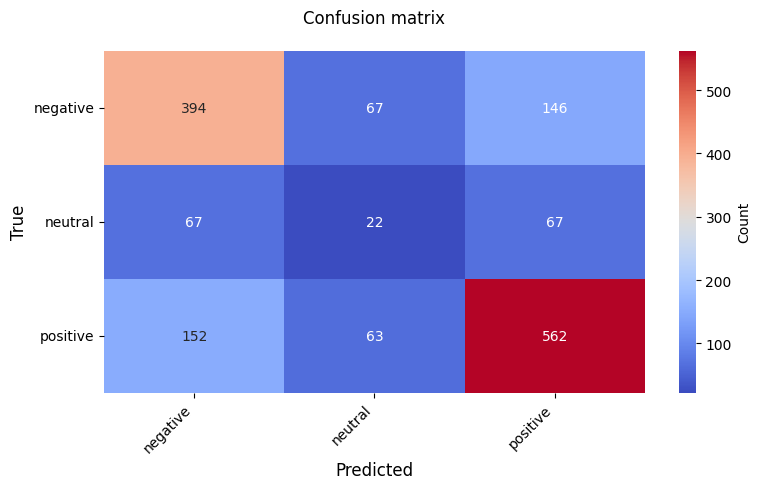

In [70]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion matrix", pad=20)
plt.ylabel("True", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Test


In [71]:
df_test = pd.read_csv("../data/processed/test.csv", encoding="utf-8")
df_test_predict = df_test.copy()
df_test_predict.head()

,brand,model,version,year,segment,comment,label
0,mitsubishi,attrage,cvt,2025,sedan,ngoại thất hiện_đại hẳn,positive
1,nissan,almera,NaN,2025,sedan,thương_hiệu ninsan chỗ chê gtr nổi_tiếng khấp ...,positive
2,mg,5,luxury,2025,sedan,xe trung_quốc thiết_kế đẹp,positive
3,hyundai,creta,n line,2025,suv,giá trưng_bày,negative
4,toyota,vios,NaN,2025,sedan,vụ tai_nạn mấy hôm trung_quốc vios sởn gai_ốc ...,negative


In [72]:
# Try prediction
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples)
preds = grid_log.best_estimator_.predict(samples_vec)
preds = le.inverse_transform(preds)

for i, (text, pred) in enumerate(zip(samples, preds), start=1):
    df_test_predict.loc[i - 1, "predicted_label"] = pred

In [73]:
df_test_predict[["label", "predicted_label"]].groupby(
    ["label", "predicted_label"]
).value_counts()

label     predicted_label
negative  negative           197
          neutral             41
          positive            66
neutral   negative            32
          neutral             13
          positive            33
positive  negative            74
          neutral             34
          positive           280
Name: count, dtype: int64

---

# Save model


In [ ]:
model_save_path = "../models/ml/"

# Save Logistic Regression model
joblib.dump(grid_log.best_estimator_, model_save_path + "logistic.pkl")
print(f"Logistic Regression model saved to {model_save_path}logistic.pkl")